# Prepare Data

In [1]:
from google.colab import files
from google.colab import drive

from keras.models import Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Softmax
from keras.engine.saving import model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import os
import sys

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

import librosa
import librosa.display

import tensorflow as tf

In [2]:
drive.mount('/content/gdrive', force_remount=True)
iemocap = "gdrive/My Drive/Public/IEMOCAP_full_release"

Mounted at /content/gdrive


# Convert into CSV

In [3]:
sessions = ["Session1", "Session2", "Session3", "Session4", "Session5"]

def convertSession(session_name):
  session_file = iemocap + "/Duration/Processed/" + session_name + ".txt"
  tokenized_lines = []

  with open(session_file) as f:
    lines = f.readlines()
    tokenizedLines = [x.split() for x in lines]

  session_csv = iemocap + "/Duration/Processed/" + session_name + ".csv"
  with open(session_csv, "w") as csv:
    audio_name = ''

    for line in tokenizedLines:
      if line[0] == "Recording":
        audio_name = line[1]
      else:
        csv.write(audio_name + ";" + line[0] + ";" + line[1] + "\n")

def convertRawToCsv():
  for session in sessions:
    convertSession(session)

# convertRawToCsv()

# Convert into data frame

In [4]:
def getSessionData(session_name):
  df = pd.read_csv(iemocap + "/Duration/Processed/" + session_name + ".csv", delimiter=";", header=None)
  df.columns = ["Audio Name", "Part", "Duration"]
  print(session_name + " count: " + str(len(df.index)))

  return df

def getDataFrame():
  result = pd.DataFrame()

  for session in sessions:
    df = getSessionData(session)
    result = result.append(df, ignore_index=True)

  return result

result = getDataFrame()
result["Duration"] = result["Duration"].apply(np.floor).astype(int)
result

Session1 count: 1819
Session2 count: 1811
Session3 count: 2136
Session4 count: 2103
Session5 count: 2170


,Audio Name,Part,Duration
0,Ses01F_impro01,F000,1
1,Ses01F_impro01,F001,1
2,Ses01F_impro01,F002,3
3,Ses01F_impro01,F003,1
4,Ses01F_impro01,F004,3
...,...,...,...
10034,Ses05M_script03_2,M041,8
10035,Ses05M_script03_2,M042,1
10036,Ses05M_script03_2,M043,2
10037,Ses05M_script03_2,M044,4


# Plot

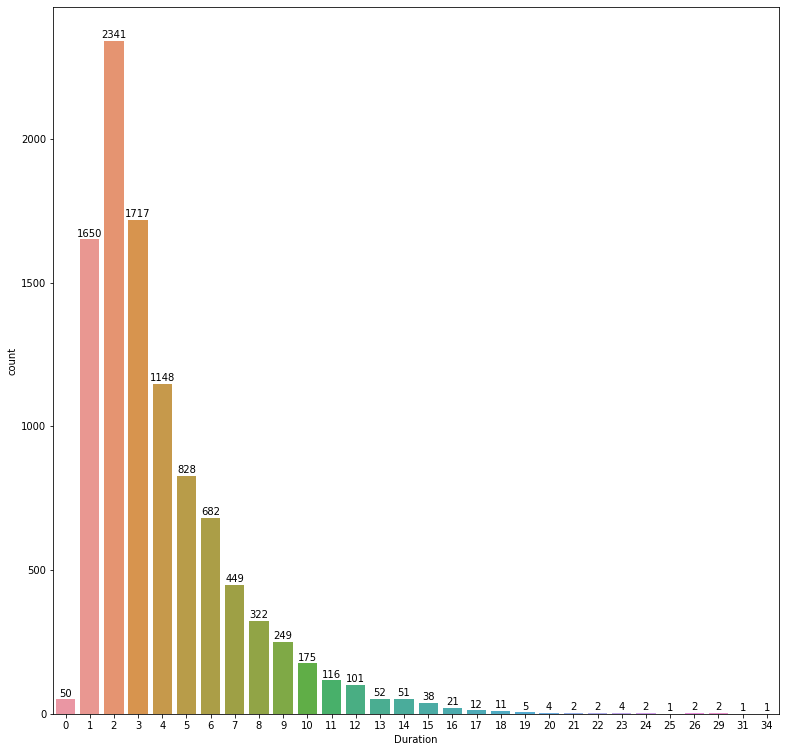

In [ ]:
plot = seaborn.countplot(x='Duration', data=result)
plot.figure.set_size_inches(13,13)

for p in plot.patches:
  height = p.get_height()
  plot.text(p.get_x() + p.get_width()/2., height + 10, '{:1.0f}'.format(height), ha="center") 

In [ ]:
print("Original data: " + str(result.count()))

count_data = result.value_counts(subset=['Duration'], sort=False).values
count_normalize = result.value_counts(subset=['Duration'], sort=False, normalize=True).values
duration = sorted(result.Duration.unique())

count_df = pd.DataFrame({"Duration": duration, "Count": count_data, "Percentage": count_normalize})
count_df.Percentage = (count_df.Percentage * 100).round(3)
count_df

Original data: Audio Name     10039
Part           10039
Duration       10039
Evaluation1        0
Evaluation2        0
Evaluation3        0
Evaluation4        0
Evaluation5        0
Evaluation6        0
Emotion        10039
dtype: int64


,Duration,Count,Percentage
0,0,50,0.498
1,1,1650,16.436
2,2,2341,23.319
3,3,1717,17.103
4,4,1148,11.435
5,5,828,8.248
6,6,682,6.794
7,7,449,4.473
8,8,322,3.207
9,9,249,2.480


# Labeling

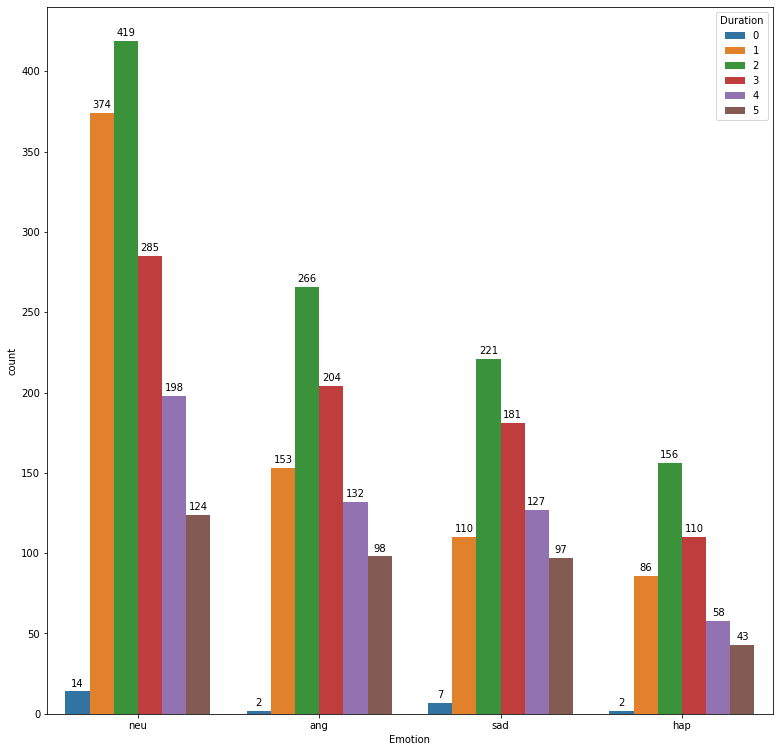

In [12]:
# emotion_column = ["Evaluation1", "Evaluation2", "Evaluation3", "Evaluation4", "Evaluation5", "Evaluation6"]

def resetEvaluation():
  # for column in emotion_column:
  #   result[column] = None

  result["Emotion"] = None

def goLabeling():
  for session in sessions:
    emotion_path = iemocap + "/" + session + "/dialog/EmoEvaluation/"

    recordings = [file.name for file in os.scandir(emotion_path) if ".txt" in file.name]
    recordings.sort()
    
    for recording in recordings:
      with open(emotion_path + recording) as f:
        lines = f.readlines()
        tokenizedLines = [x.split() for x in lines if "Ses0" in x]

        for part in tokenizedLines:
          line_name = part[3]
          line_label = part[4]
          line_queries = line_name.split("_")
          
          line_part = line_queries[-1]
          line_queries.remove(line_part)

          line_name = "_".join(line_queries)

          search_query_name = ""
          search_query_part = line_queries[-1]
          search_result = result.loc[(result["Audio Name"] == line_name) & (result["Part"] == line_part), "Emotion"]
          search_count = search_result.shape[0]
          
          if search_count == 0:
            print("ERROR: No audio part found: ")
          elif search_count > 1:
            print("ERROR: Multiple audio found: ")
          else:
            result.loc[(result["Audio Name"] == line_name) & (result["Part"] == line_part), "Emotion"] = line_label

def getClassificationReport():
  max_duration = 5

  categorical_data = result.loc[
    (result["Duration"] < max_duration + 1) &
    (
      (result["Emotion"] == 'neu') |
      (result["Emotion"] == 'ang') |
      (result["Emotion"] == 'hap') |
      (result["Emotion"] == 'sad') 
    )
  ]
  
  categorical_plot = seaborn.countplot(x="Emotion", hue="Duration", data=categorical_data)
  categorical_plot.figure.set_size_inches(13,13)

  for p in categorical_plot.patches:
    height = p.get_height()
    categorical_plot.text(p.get_x() + p.get_width()/2., height + 3, '{:1.0f}'.format(height), ha="center") 

  return categorical_data

resetEvaluation()
goLabeling()
categorical_data = getClassificationReport()

# Selection and Splitting

In [58]:
def checkAndCreateDirectory(filename):
  if not os.path.exists(os.path.dirname(filename)):
    try:
        os.makedirs(os.path.dirname(filename))
    except OSError as exc: # Guard against race condition
        print(exc.errno)
        if exc.errno != errno.EEXIST:
            raise

def getMfccValue(audio_path):
  audio_file, sample_rate = librosa.load(audio_path)
  S = librosa.feature.mfcc(y=audio_file, sr=48000)

  # TODO: Parameter MFCC, number of coefficient, Normalization
  # asd

  return S

def transformAudio(duration, max_duration):
  X = [] # Data
  Y = [] # Label

  # Get selectioned data
  durationed_data = result.loc[
    (result["Duration"] > duration - 1) &
    (result["Duration"] < max_duration + 1) &
    (
      (result["Emotion"] == 'neu') |
      (result["Emotion"] == 'ang') |
      (result["Emotion"] == 'hap') |
      (result["Emotion"] == 'sad') 
    )
  ]
  
  durationed_length = len(durationed_data)
  # 1s -> 723
  # 2s -> 1062

  # Iterate every data
  for index, row in durationed_data.iterrows():
    print("Saving " + str(durationed_length) + " " + str(index), end=" | ")

    if durationed_length % 10 == 0: print("\n")
    durationed_length -= 1

    # Get Label
    label = row["Emotion"]
    label_hot = [0, 0, 0, 0]
    
    if    (label == "neu"): label_hot = [1, 0, 0, 0]
    elif  (label == "ang"): label_hot = [0, 1, 0, 0]
    elif  (label == "hap"): label_hot = [0, 0, 1, 0]
    elif  (label == "sad"): label_hot = [0, 0, 0, 1]
 
    np.where(np.array(label_hot) == 1)[0][0]

    # Get Audio
    audio_prefix = row["Audio Name"][:5]
    audio_session = "Error"

    if    (audio_prefix == 'Ses01'): audio_session = "Session1"
    elif  (audio_prefix == 'Ses02'): audio_session = "Session2"
    elif  (audio_prefix == 'Ses03'): audio_session = "Session3"
    elif  (audio_prefix == 'Ses04'): audio_session = "Session4"
    elif  (audio_prefix == 'Ses05'): audio_session = "Session5"

    audio_path = iemocap + '/' + audio_session + '/sentences/wav/' + row["Audio Name"] + '/' + row["Audio Name"] + '_' + row["Part"] + '.wav'

    # Get Mfcc
    mfcc = getMfccValue(audio_path)
    mfcc_length = mfcc.shape[1]

    mfcc_slice = 50 * duration

    # Add all slices to X
    #   mfcc = np.pad(mfcc, pad_width=((0, 0), (0, ((50 * duration) - mfcc_length))), mode='constant')
    for mfcc_partial in range(int(mfcc_length/mfcc_slice)):
      start = mfcc_partial * mfcc_slice
      end = (mfcc_partial + 1) * mfcc_slice
      mfcc_partial_result = mfcc[:,start:end]

      if (mfcc_partial_result.shape[1] != mfcc_slice) | (mfcc_partial_result.shape[0] != 20):
        print("ERROR Mfcc " + index + row)
        break
      
      X.append(mfcc_partial_result)
      Y.append(label_hot)

  return np.array(X), np.array(Y)

def clearLocalFolder():
  !rm -rf transformed_image

def downloadLocalData():
  !zip -r /content/transformed_image.zip /content/transformed_image
  files.download("/content/transformed_image.zip")

def getDuration():
  audio_file, sample_rate = librosa.load('/content/gdrive/My Drive/Public/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M008.wav')
  duration = librosa.get_duration(y=audio_file, sr=sample_rate)
  print(duration)

  S = librosa.feature.mfcc(y=audio_file, sr=48000)
  print(S.shape)

# clearLocalFolder()
# downloadLocalData()
# getDuration()

# Imbalance data
X, Y = transformAudio(1,3)

Saving 2565 0 | Saving 2564 1 | Saving 2563 2 | Saving 2562 12 | Saving 2561 31 | Saving 2560 35 | 

Saving 2559 38 | Saving 2558 42 | Saving 2557 45 | Saving 2556 46 | Saving 2555 48 | Saving 2554 49 | Saving 2553 60 | Saving 2552 62 | Saving 2551 66 | Saving 2550 68 | 

Saving 2549 69 | Saving 2548 70 | Saving 2547 72 | Saving 2546 73 | Saving 2545 76 | Saving 2544 77 | Saving 2543 78 | Saving 2542 80 | Saving 2541 84 | Saving 2540 85 | 

Saving 2539 86 | Saving 2538 87 | Saving 2537 90 | Saving 2536 93 | Saving 2535 95 | Saving 2534 96 | Saving 2533 101 | Saving 2532 102 | Saving 2531 103 | Saving 2530 106 | 

Saving 2529 108 | Saving 2528 109 | Saving 2527 110 | Saving 2526 111 | Saving 2525 116 | Saving 2524 118 | Saving 2523 119 | Saving 2522 125 | Saving 2521 126 | Saving 2520 129 | 

Saving 2519 134 | Saving 2518 148 | Saving 2517 149 | Saving 2516 150 | Saving 2515 152 | Saving 2514 154 | Saving 2513 155 | Saving 2512 156 | Saving 2511 157 | Saving 2510 159 | 

Saving 2509 160

In [62]:
data_training_percent = 0.6
data_validation_percent = 0.2
data_testing_percent = 0.2

data_training_length = int(len(X) * data_training_percent)
data_validation_length = int(len(X) * (data_training_percent + data_validation_percent))

if (data_training_percent + data_validation_percent + data_testing_percent != 1):
  print("Error in percentage")

# TODO
# Shuffle

x_train = X[                      : data_training_length]
x_val   = X[data_training_length  : data_validation_length]
x_test  = X[data_validation_length: ]

y_train = Y[                      : data_training_length]
y_val   = Y[data_training_length  : data_validation_length]
y_test  = Y[data_validation_length: ]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20, 50, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 24, 128)        1280      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 11, 128)        147584    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 5, 128)         147584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               82048     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1651

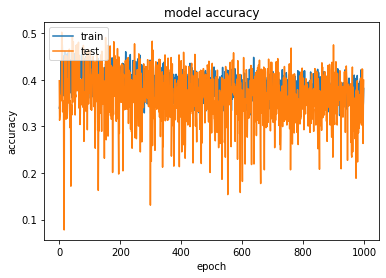

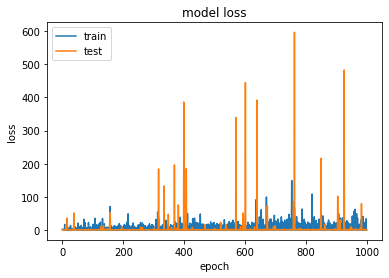

In [65]:
def plot_result(model, history):
  # list all data in history
  print(history.history.keys())

  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def save_model(model, filename):
  checkAndCreateDirectory("model/test.txt")
  model.summary()

  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  with open("model/" + filename + ".json", "w") as json_file:
    model_json = model.to_json()
    json_file.write(model_json)

def buildModel():
  model_input = Input(shape=(20, 50, 1))

  model = Conv2D(128, kernel_size=3, strides=2)(model_input)
  model = Conv2D(128, kernel_size=3, strides=2)(model)
  model = Conv2D(128, kernel_size=3, strides=2)(model)
  
  model = Flatten()(model)

  model = Dense(128)(model)
  model = Dense(128)(model)
  model = Dense(128)(model)

  model = Dense(4, activation='softmax')(model)
  
  # Model compile
  model = Model(inputs=[model_input], outputs=[model])
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  
  # Visualize & Save Model
  save_model(model, "struct_model")

  # Checkpoint
  basepath = '/content/model/weight_model'
  best_checkpoint = ModelCheckpoint(basepath +'_{epoch:02d}_{loss:.2f}_{accuracy:.2f}_{val_loss:.2f}_{val_accuracy:.2f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
  callback_list = [best_checkpoint]

  history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val),
    batch_size=1, 
    epochs=1000,
    callbacks=callback_list
  )

  return model, history

!rm -rf /content/model
model, history = buildModel()
plot_result(model, history)

# Testing

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(
    ""
    "Prediction Loss: %2d\n"
    "Prediction Accuracy: %2d%%"
    ""
    % (loss, accuracy * 100))

7/7 [==============================] - 0s 4ms/step - loss: 1.2857 - accuracy: 0.5117
Prediction Loss:  1
Prediction Accuracy: 51%


# Analysis

In [ ]:
target_names = ['neu', 'ang', 'hap', "sad"]

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

y_decoded = []
for pred in y_test:
  decoded = np.where(pred == 1)[0][0]
  y_decoded.append(decoded)

print('Confusion Matrix')
print(confusion_matrix(y_decoded, y_pred))

print('\n\nClassification Report')
print(classification_report(y_decoded, y_pred, target_names=target_names))

Confusion Matrix
[[69  3  4  9]
 [23 21  1  3]
 [14 10  2  8]
 [27  2  0 17]]


Classification Report
              precision    recall  f1-score   support

         neu       0.52      0.81      0.63        85
         ang       0.58      0.44      0.50        48
         hap       0.29      0.06      0.10        34
         sad       0.46      0.37      0.41        46

    accuracy                           0.51       213
   macro avg       0.46      0.42      0.41       213
weighted avg       0.48      0.51      0.47       213

